In [1]:
from typing import Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.random.set_seed(42)

## Define Augmenters

In [3]:
def random_crop_and_resize(x_in: tf.Tensor,
                           crop_size: Tuple[float, float] = (0.08, 1.0),
                           aspect_range: Tuple[float, float] = (0.75, 1.33),
                           num_tries: int = 100) -> tf.Tensor:
    """
        Random crop and resize based on crop size and aspect ratio ranges.
            1) Sample crop size and aspect ratio.
            2) Get crop dimensions.
            3) Adjust crop dimensions to aspect ratio.
            3) Check that the crop dimensions are valid.
            4) Crop image based on valid crop dimensions and resize to original dimensions.
            5) Return original image if valid crop can't be generated within num_tries.

        args:
            x_in: tf.Tensor - Input image tensor.
            crop_size: Tuple[float, float] - Crop size range (proprtion of input image).
            aspect_range: Tuple[float, float] - Aspect ratio range.
            num_tries: int - Number of tries to generate crop within given constraints.
        returns:
            x_out: tf.Tensor - Cropped image tensor.
    """
    
    crop_size_min = crop_size[0]
    crop_size_max = crop_size[1]
    
    aspect_ratio_min = aspect_range[0]
    aspect_ratio_max = aspect_range[1]
    
    w_original = tf.cast(tf.shape(x_in)[1], tf.float32)
    h_original = tf.cast(tf.shape(x_in)[0], tf.float32)

    for _ in tf.range(num_tries):
        # randomly get crop area and aspect ratio
        crop_size = tf.random.uniform(
            (), minval = crop_size_min, maxval = crop_size_max)
        aspect_ratio = tf.random.uniform(
            (), minval = aspect_ratio_min, maxval = aspect_ratio_max)

        # calculate the desired height and width of crop based on crop size
        num_pixels_original = h_original * w_original
        num_pixels_new = tf.math.floor(num_pixels_original * crop_size)

        w_new = tf.math.floor(tf.math.sqrt(aspect_ratio * num_pixels_new))
        h_new = tf.math.floor(num_pixels_new / w_new)
                
        if w_new <= w_original and h_new <= h_original:
            # randomly crop based on dimensions
            crop = tf.image.random_crop(x_in, (h_new, w_new))
            crop = crop[tf.newaxis, ..., tf.newaxis]
            crop_resized = tf.squeeze(tf.image.resize(crop, [x_in.shape[0], x_in.shape[1]]))
            return crop_resized
    return x_in
    

## Test Crop and Resize

In [4]:
image_test = cv2.imread('lenna.png')
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)
image_test = image_test / 255.

In [5]:
image_test_tensor = tf.convert_to_tensor(image_test, dtype = tf.float32)
# image_test_tensor = tf.expand_dims(image_test_tensor, axis = 0)
# image_test_tensor  = tf.expand_dims(image_test_tensor, axis = -1)

2022-06-05 00:14:26.637079: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
image_test_tensor.shape

TensorShape([512, 512])

In [63]:
crop = random_crop_and_resize(image_test_tensor)

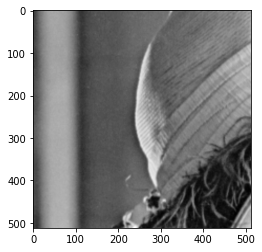

In [64]:
plt.imshow(np.squeeze(crop.numpy()), cmap = 'gray')